In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from collections import defaultdict

In [4]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP 220/small_books_rating.csv")

dataset = dataset[dataset['review/score'] != 3]
dataset['binary_label'] = dataset['review/score'].apply(lambda x:1 if x>=4 else 0 if x <= 2 else None)
dataset.shape

(30000, 11)

In [5]:
def pos_features(text): # feature 1
    tokens = word_tokenize(text)  # Tokenize the text
    pos_tags = pos_tag(tokens)  # Get POS tags

    # Count the occurrences of each POS type
    pos_counts = Counter(tag for word, tag in pos_tags)

    # Get counts of specific POS categories
    noun_count = sum(pos_counts[tag] for tag in ['NN', 'NNS', 'NNP', 'NNPS'])
    verb_count = sum(pos_counts[tag] for tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'])
    adj_count = sum(pos_counts[tag] for tag in ['JJ', 'JJR', 'JJS'])

    return pd.Series({'noun_count': noun_count, 'verb_count': verb_count, 'adj_count': adj_count})

pos_features_df = dataset['review/text'].apply(pos_features)
pos_features_df.head()

,noun_count,verb_count,adj_count
0,22,13,7
1,76,40,19
2,98,39,30
3,256,64,48
4,81,38,27


In [6]:
"""def get_sentiment_score(text):
    analyzer = TextBlob(text)
    sentiment = analyzer.sentiment.polarity # sentiment polairty score
    return sentiment

dataset['sentiment_score'] = dataset['review/text'].apply(get_sentiment_score) # feature 1
"""

In [7]:
# the length of reviews
dataset['review_length'] = dataset['review/text'].apply(lambda x: len(x.split())) # feature 2

In [22]:
dataset['review_length']

,review_length
0,86
1,252
2,310
3,560
4,273
...,...
37495,99
37496,29
37497,22
37498,34


In [8]:
dataset.shape

(30000, 13)

In [9]:
vectorizer = CountVectorizer(max_features=100)
word_freq_matrix = vectorizer.fit_transform(dataset['review/text']) # frequency of words
word_freq_df = pd.DataFrame(word_freq_matrix.toarray(), columns=vectorizer.get_feature_names_out()) # feature 3

In [24]:
word_freq_df

,about,after,all,also,an,and,any,are,as,at,...,were,what,when,which,who,will,with,would,you,your
0,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,2,0,4,0
1,0,2,2,0,0,9,0,0,4,2,...,0,1,0,0,1,0,1,0,0,0
2,0,0,1,0,1,16,0,1,0,2,...,1,1,0,2,4,2,4,0,2,2
3,0,0,0,0,3,27,2,1,4,2,...,0,0,2,2,3,3,2,1,1,0
4,3,1,0,1,2,8,1,2,2,0,...,1,1,0,0,0,1,2,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,0,0,0,0,3,0,0,0,0,...,0,1,1,1,0,0,0,0,1,0
29996,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
29997,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29998,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


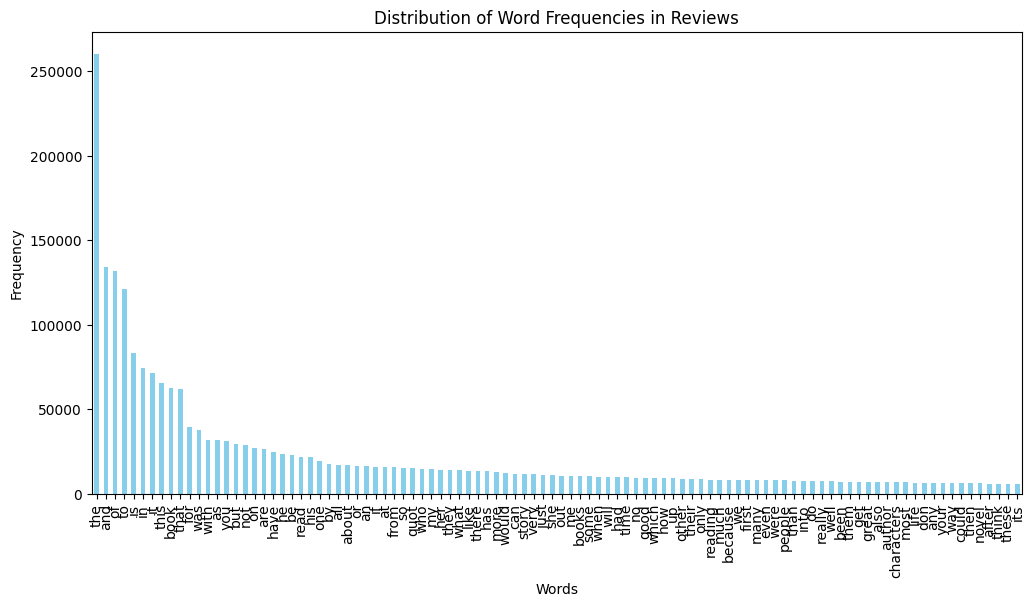

In [23]:
# Sum up the word frequencies across all reviews
word_counts = word_freq_df.sum(axis=0).sort_values(ascending=False)

# Plot the distribution of word frequencies
plt.figure(figsize=(12, 6))
word_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Word Frequencies in Reviews")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

Training set shape: (25500, 100), (25500,)
Test set shape: (4500, 100), (4500,)
binary_label
0    2274
1    2226
Name: count, dtype: int64


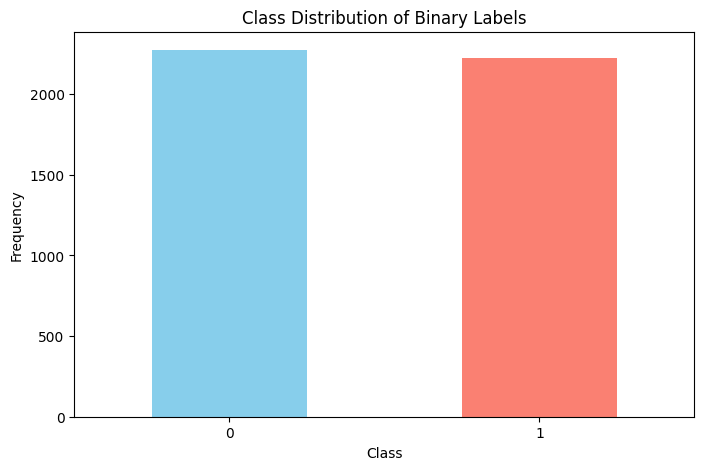

In [10]:
X_f1 =  word_freq_df[:]# using feature 3
y = dataset['binary_label']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_f1, y, test_size=0.15, random_state=42, shuffle=True)

print(f'Training set shape: {X_train1.shape}, {y_train1.shape}')
print(f'Test set shape: {X_test1.shape}, {y_test1.shape}')

class_distribution = y_test1.value_counts()
print(class_distribution)

plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution of Binary Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
plt.show()

In [11]:
# Feature Scaling
sc = StandardScaler()

X_train1 = sc.fit_transform(X_train1)
X_test1 = sc.transform(X_test1)

In [12]:
# Naive Bayes - 1
classifier = GaussianNB()
classifier.fit(X_train1, y_train1)

y_pred1 = classifier.predict(X_test1)

# Evaluate the model
accuracy = accuracy_score(y_test1, y_pred1)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test1, y_pred1))
print(confusion_matrix(y_test1, y_pred1))

Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.66      0.33      0.44      2274
           1       0.55      0.82      0.66      2226

    accuracy                           0.58      4500
   macro avg       0.60      0.58      0.55      4500
weighted avg       0.60      0.58      0.55      4500

[[ 756 1518]
 [ 393 1833]]


In [ ]:
# SVM - 1
classifier = LinearSVC()
classifier.fit(X_train1, y_train1)
y_pred1 = classifier.predict(X_test1)

# Evaluate the model
accuracy = accuracy_score(y_test1, y_pred1)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test1, y_pred1))
print(confusion_matrix(y_test1, y_pred1))

Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      2274
           1       0.69      0.74      0.71      2226

    accuracy                           0.71      4500
   macro avg       0.71      0.71      0.71      4500
weighted avg       0.71      0.71      0.71      4500

[[1537  737]
 [ 583 1643]]


In [ ]:
# Decision Tree - 1
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
classifier.fit(X_train1, y_train1)

y_pred1 = classifier.predict(X_test1)

# Evaluate the model
accuracy = accuracy_score(y_test1, y_pred1)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test1, y_pred1))
print(confusion_matrix(y_test1, y_pred1))

Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.64      0.63      0.64      2274
           1       0.63      0.65      0.64      2226

    accuracy                           0.64      4500
   macro avg       0.64      0.64      0.64      4500
weighted avg       0.64      0.64      0.64      4500

[[1434  840]
 [ 790 1436]]


Training set shape: (25500, 104), (25500,)
Test set shape: (4500, 104), (4500,)
binary_label
0    2274
1    2226
Name: count, dtype: int64


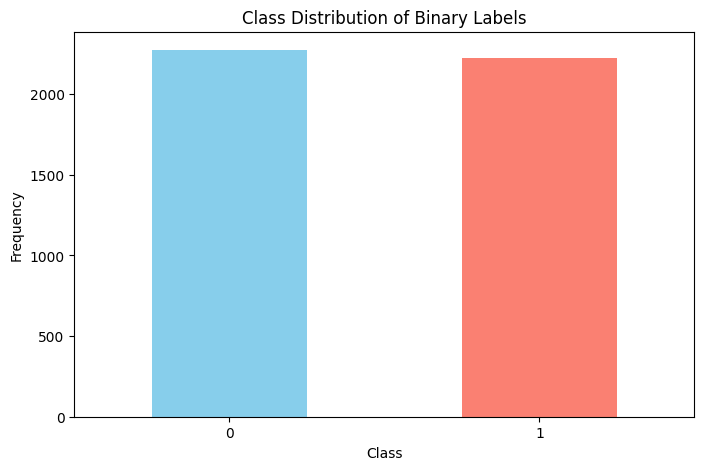

In [13]:
X_f2 = pd.concat([word_freq_df.reset_index(drop=True), pos_features_df.reset_index(drop=True), dataset['review_length'].reset_index(drop=True)], axis=1)
y = dataset['binary_label']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_f2, y, test_size=0.15, random_state=42, shuffle=True)

print(f'Training set shape: {X_train2.shape}, {y_train2.shape}')
print(f'Test set shape: {X_test2.shape}, {y_test2.shape}')

class_distribution = y_test2.value_counts()
print(class_distribution)

plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution of Binary Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
plt.show()

In [14]:
# Feature Scaling
sc = StandardScaler()

X_train2 = sc.fit_transform(X_train2)
X_test2 = sc.transform(X_test2)

In [15]:
classifier = GaussianNB()
classifier.fit(X_train2, y_train2)

y_pred2 = classifier.predict(X_test2)

# Evaluate the model
accuracy = accuracy_score(y_test2, y_pred2)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test2, y_pred2))
print(confusion_matrix(y_test2, y_pred2))

Accuracy: 0.57
              precision    recall  f1-score   support

           0       0.66      0.33      0.44      2274
           1       0.55      0.82      0.66      2226

    accuracy                           0.57      4500
   macro avg       0.60      0.58      0.55      4500
weighted avg       0.60      0.57      0.55      4500

[[ 746 1528]
 [ 391 1835]]


In [ ]:
# SVM - 2
classifier = LinearSVC()
classifier.fit(X_train2, y_train2)

y_pred2 = classifier.predict(X_test2)

# Evaluate the model
accuracy = accuracy_score(y_test2, y_pred2)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test2, y_pred2))
print(confusion_matrix(y_test2, y_pred2))

Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      2274
           1       0.70      0.74      0.72      2226

    accuracy                           0.71      4500
   macro avg       0.71      0.71      0.71      4500
weighted avg       0.71      0.71      0.71      4500

[[1567  707]
 [ 585 1641]]


In [ ]:
# Decision Tree - 2
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
classifier.fit(X_train2, y_train2)

y_pred2 = classifier.predict(X_test2)

# Evaluate the model
accuracy = accuracy_score(y_test2, y_pred2)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test2, y_pred2))
print(confusion_matrix(y_test2, y_pred2))

Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.64      0.61      0.62      2274
           1       0.62      0.64      0.63      2226

    accuracy                           0.63      4500
   macro avg       0.63      0.63      0.63      4500
weighted avg       0.63      0.63      0.63      4500

[[1392  882]
 [ 793 1433]]


In [16]:
# Converting string to float
def helpfulness_to_float(value):
    try:
        x, y = value.split('/')
        return float(x) / float(y) if float(y) != 0 else 0.0  # Avoid division by zero
    except (ValueError, ZeroDivisionError):
        return None

#'review/helpfulness' column
dataset['review/helpfulness'] = dataset['review/helpfulness'].apply(helpfulness_to_float)

Training set shape: (25500, 102), (25500,)
Test set shape: (4500, 102), (4500,)
binary_label
0    2274
1    2226
Name: count, dtype: int64


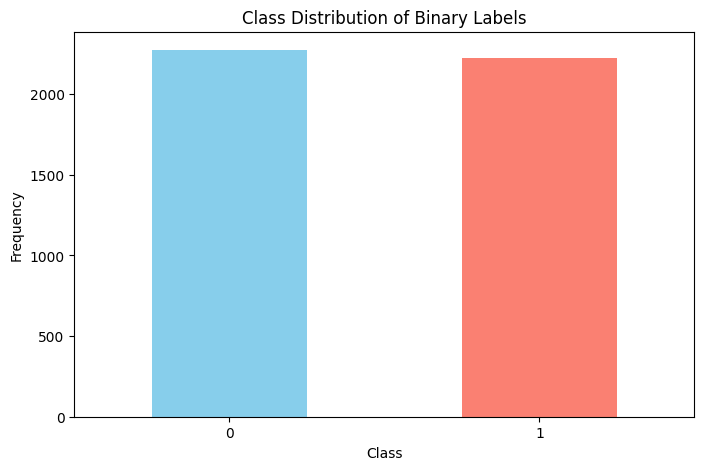

In [17]:
X_f3 = np.hstack(([word_freq_df.reset_index(drop=True), dataset[['review_length', 'review/helpfulness']]]))
y_f3 = dataset['binary_label']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_f3, y_f3, test_size=0.15, random_state=42, shuffle=True)

print(f'Training set shape: {X_train3.shape}, {y_train3.shape}')
print(f'Test set shape: {X_test3.shape}, {y_test3.shape}')

class_distribution = y_test3.value_counts()
print(class_distribution)

plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution of Binary Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
plt.show()

In [18]:
# Feature Scaling
sc = StandardScaler()

X_train3 = sc.fit_transform(X_train3)
X_test3 = sc.transform(X_test3)

In [19]:
# Naive Bayes - 3
classifier = GaussianNB()
classifier.fit(X_train3, y_train3)

y_pred3 = classifier.predict(X_test3)

# Evaluate the model
accuracy = accuracy_score(y_test3, y_pred3)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test3, y_pred3))
print(confusion_matrix(y_test3, y_pred3))

Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.67      0.33      0.44      2274
           1       0.55      0.83      0.66      2226

    accuracy                           0.58      4500
   macro avg       0.61      0.58      0.55      4500
weighted avg       0.61      0.58      0.55      4500

[[ 754 1520]
 [ 378 1848]]


In [ ]:
classifier = LinearSVC()
classifier.fit(X_train3, y_train3)

y_pred3 = classifier.predict(X_test3)

# Evaluate the model
accuracy = accuracy_score(y_test3, y_pred3)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test3, y_pred3))
print(confusion_matrix(y_test3, y_pred3))

Accuracy: 0.70
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      2274
           1       0.69      0.73      0.71      2226

    accuracy                           0.70      4500
   macro avg       0.71      0.70      0.70      4500
weighted avg       0.71      0.70      0.70      4500

[[1544  730]
 [ 599 1627]]


In [ ]:
sc = StandardScaler()

X_train3 = sc.fit_transform(X_train3)
X_test3 = sc.transform(X_test3)

classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
classifier.fit(X_train3, y_train3)

y_pred3 = classifier.predict(X_test3)

# Evaluate the model
accuracy = accuracy_score(y_test3, y_pred3)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test3, y_pred3))
print(confusion_matrix(y_test3, y_pred3))

Accuracy: 0.69
              precision    recall  f1-score   support

           0       0.70      0.69      0.70      2274
           1       0.69      0.70      0.69      2226

    accuracy                           0.69      4500
   macro avg       0.69      0.69      0.69      4500
weighted avg       0.69      0.69      0.69      4500

[[1570  704]
 [ 669 1557]]


In [21]:
# Naive Bayes Classifier - Part C
class CustomNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}
        self.classes = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        feature_count = X.shape[1]
        self.priors = {cls: np.log(np.mean(y == cls)) for cls in self.classes}
        self.likelihoods = {cls: defaultdict(lambda: np.zeros(feature_count)) for cls in self.classes}

        # Calculate likelihoods (mean and variance for Gaussian NB)
        for cls in self.classes:
            X_cls = X[y == cls]
            self.likelihoods[cls]['mean'] = np.mean(X_cls, axis=0)
            self.likelihoods[cls]['var'] = np.var(X_cls, axis=0) + 1e-6  # small value for stability

    def predict(self, X):
        preds = []
        for x in X:
            posteriors = {}
            for cls in self.classes:
                prior = self.priors[cls]
                mean = self.likelihoods[cls]['mean']
                var = self.likelihoods[cls]['var']
                # Gaussian Naive Bayes log likelihood
                log_likelihood = -0.5 * np.sum(np.log(2. * np.pi * var)) - 0.5 * np.sum(((x - mean) ** 2) / var)
                posteriors[cls] = prior + log_likelihood
            preds.append(max(posteriors, key=posteriors.get))
        return np.array(preds)

# Naive Bayes - 1
classifier = CustomNaiveBayes()
classifier.fit(X_train1, y_train1)
y_pred1 = classifier.predict(X_test1)

accuracy = accuracy_score(y_test1, y_pred1)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test1, y_pred1))
print(confusion_matrix(y_test1, y_pred1))

# Naive Bayes - 2
classifier = CustomNaiveBayes()
classifier.fit(X_train2, y_train2)
y_pred2 = classifier.predict(X_test2)

accuracy = accuracy_score(y_test2, y_pred2)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test2, y_pred2))
print(confusion_matrix(y_test2, y_pred2))

# Naive Bayes - 3
classifier = CustomNaiveBayes()
classifier.fit(X_train3, y_train3)
y_pred3 = classifier.predict(X_test3)

accuracy = accuracy_score(y_test3, y_pred3)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test3, y_pred3))
print(confusion_matrix(y_test3, y_pred3))

Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.66      0.33      0.44      2274
           1       0.55      0.82      0.66      2226

    accuracy                           0.58      4500
   macro avg       0.60      0.58      0.55      4500
weighted avg       0.60      0.58      0.55      4500

[[ 756 1518]
 [ 393 1833]]
Accuracy: 0.57
              precision    recall  f1-score   support

           0       0.66      0.33      0.44      2274
           1       0.55      0.82      0.66      2226

    accuracy                           0.57      4500
   macro avg       0.60      0.58      0.55      4500
weighted avg       0.60      0.57      0.55      4500

[[ 746 1528]
 [ 391 1835]]
Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.67      0.33      0.44      2274
           1       0.55      0.83      0.66      2226

    accuracy                           0.58      4500
   macro avg       0.61      